# Introduction

## Ema's Original Formulation

Schematically, Ema's idea is to model the probability of a new pixel being settled, conditional on the initial settlement pattern, as 

$$p_i = \sum_j a_{ij} p_j(i; \theta)\;,$$

where $a_{ij}$ is the probability that pixel $i$ is of "type" $j$ (e.g. $j \in \{\text{urban, rural}\})$, and $p_j(i; \theta)$ is the probability of type-$j$ settlement given the initial settlement pattern and some parameters $\theta$. 

Ema's original form of this model is to take $a_{ij} = \alpha_j$ to be a parameter that is constant for all pixels $i$, and and to take $p_j(i; \theta$ to have the form 

$$ p_j(i; \theta) = \frac{\sum_{k \in \mathcal{W}_j} d_{ik}^{-\gamma}}{\sum_{k \in \mathcal{W}} d_{ik}^{-\gamma}}\;.$$ 

In this expression, $\mathcal{W}$ is the entire map and $\mathcal{W}_j$ is the set of all settled pixels of type $j$. $\mathcal{W}_j$ is determined according to a size-based thresholding, so, for example, clusters of certain size are considered to be urban. 

## A Small Modification

The modification I suggest to Ema's original formulation is pretty simple: we add a parameter and pass the first expression through a logistic sigmoid function: 

$$p_i = \sigma\left(\sum_j a_{ij} p_j(i; \theta) + \beta\right)\;,$$

where $\sigma(x) = (1 + e^{-x})^{-1}$. This model turns out to have considerably richer behavior (i.e. we "get our money's worth" for the extra parameter $\beta$), and has parameters that are easier to estimate. It mainly does this by avoiding mathematical difficulties in Ema's original formulation; for example, unlike the very first expression, the modified one is always a correctly normalized probability. 

## The Method

I had previously been convinced that the correct way to model the settlement phenomena would be using latent-variable methods, in which case we could apply nice alternating-projection algorithms to the problem. However, the most performant approach so far has been the "dumb" approach associated with performing simple maximum-likelihood estimation using a Python solver. 

Let's see a quick demonstration of the method. What we're going to do is:

1. Construct an initial map. 
2. Simulate one time-step of the evolution based on some known parameters. 
3. Treat this simulation as "data" and attempt to learn what the parameters were. 

As we'll see, this framework is fairly successful at this task. This is important: if it weren't, the parameters wouldn't be "identifiable," and the problem of parameter estimation would be impossible under this model. 

Let's see this in action! 

# Demo

The code for the `urban_growth.simulator` and `urban_growth.estimator` classes is located in the same GitHub repo. 

In [1]:
from urban_growth.simulator import *
from urban_growth.estimator import *
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

## Set Parameters

We have parameters for: the initial map configuration, the model type, the size threshold determining the rural/urban distinction, and the $\alpha$, $\beta$, and $\gamma$ above. We also have a geographic mask that makes some areas harder to settle than others. In this example, the geographic mask discourages settlement on the west and encourages settlement in the east. 

In [13]:
# Initial Configuration. 
L = 150
rho = .47
blur = 3

# model type
model = 'logistic'

# rural-to-urban threshold
T_vec = [100]

# dynamical parameters
pars = {'alpha' : np.array([140, 60]),
        'gamma' : np.array([1.0, 2.8]),
        'beta' : np.array([-10])
       }

trunc = 50

# geographic mask
geo = np.ones((L, L))

for i in np.arange(0, L):
    geo[:,i] = 1.0*i / L 

Now we'll create a random matrix to be our initial condition, construct a `simulator` object based on that matrix, and then run the dynamics for one time-step. In the plot below, white spots are old settlements, pink spots are new settlements, and blue spots are unsettled. 

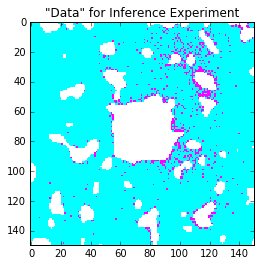

In [14]:
M0 = random_mat(L, rho, blur = blur)
m = simulator(M0 = M0, geo = geo, model = model, trunc = trunc)

M1 = m.dynamics(T_vec = T_vec,
                n_iters = 1, 
                verbose = False,  
                **pars)

X = M1 - m.M0
X[m.M0 == 1] = np.nan
im = plt.imshow(X, interpolation = 'nearest', cmap = 'cool')
plt.title('"Data" for Inference Experiment')

## Estimation

Now we'll initialize an estimator and prepare it for the estimation task: 

In [17]:
e = estimator(M0 = M0, geo = geo, model = model)
e.update_morphology()
e.make_dist_array()
e.partition_clusters(T_vec)
e.partition_dist_array()

The log-likelihood of the data under the true parameters is an important quantity: if the log-likelihood optimization step below achieves a similar likelihood and reasonable parameters, then that's indication that we've achieved a "good" result. 

In [18]:
e.logistic_log_likelihood(X, 
                          normalized = True, 
                          use_grad = False, 
                          **pars)

urban_growth/estimator.py:22: RuntimeWarning: divide by zero encountered in log
  ll = np.nansum(X*np.log(d)+(1-X)*np.log(1-d))
urban_growth/estimator.py:22: RuntimeWarning: invalid value encountered in multiply
  ll = np.nansum(X*np.log(d)+(1-X)*np.log(1-d))


-0.12146132675160774

Now we'll conduct estimation. I've initialized the model with some parameters that are intended to be "not too crazy" but also deliberately quite different from the true parameters. For example, the $\alpha$s have switched in relative size, as have the $\gamma$s. 

In [19]:
pars_0 = {'alpha' : np.array([50, 80]),
          'gamma' : np.array([3.5, 2.8]), 
          'beta'  : np.array([-2])
       }

pars_hat, ll_hat, h_inv = e.logistic_ML(X, 
                                        pars_0, 
                                        use_grad = True, 
                                        opts = {'disp' : False})
print ll_hat

-0.121398348864


urban_growth/estimator.py:24: RuntimeWarning: invalid value encountered in divide
  coef = X / d - (1 - X) / (1 - d)


The optimal function value is close to the true data, log-likelihood, which is quite encouraging. Let's compare parameters: 

In [20]:
np.set_printoptions(precision=4)

print "True alpha: " + str(pars['alpha']) + ' || Estimated: ' + str(pars_hat[0:2])
print "True alpha: " + str(pars['gamma']) + ' || Estimated: ' + str(pars_hat[2:4])
print "True alpha: " + str(pars['beta']) + ' || Estimated: ' + str(pars_hat[4])

True alpha: [140  60] || Estimated: [ 148.1428   59.9739]
True alpha: [ 1.   2.8] || Estimated: [ 0.9502  2.7978]
True alpha: [-10] || Estimated: -10.3235212867


Overall, we've come quite close to the true parameters, despite the somewhat deceptive beginning.  

## Estimate Precision

How confident are we in our estimates based on the data? We can get a sense for this based on the inverse Hessian of the log-likelihood, conveniently returned by our maximum-likelihood routine. We can use this to get approximate confidence intervals for the parameters. Note that I am ignoring the parameter covariances, which we ought to treat in the full paper. 

In [21]:
sigma = np.sqrt(np.diag(h_inv) / np.nansum(np.isfinite(X)))

upper = pars_hat + 2 * sigma
v = np.concatenate((pars['alpha'], pars['gamma'], pars['beta']))
lower = pars_hat - 2 * sigma

for j in range(v.shape[0]):
    if lower[j] < v[j] < upper[j]:
        print "True param within 95% confidence interval"
    else:
        print "True param NOT within 95% confidence interval"
            

True param within 95% confidence interval
True param within 95% confidence interval
True param within 95% confidence interval
True param within 95% confidence interval
True param within 95% confidence interval


Here's a quick view of the true parameters and estimates: the true parameters are the middle row; the upper bounds of the confidence intervals are on top and the lower bounds on the bottom. 

In [22]:
print np.concatenate((upper[np.newaxis,], 
                      v[np.newaxis,], 
                      lower[np.newaxis,]), axis = 0)

[[ 164.1169   66.909     1.0169    2.9078   -9.5547]
 [ 140.       60.        1.        2.8     -10.    ]
 [ 132.1688   53.0388    0.8835    2.6878  -11.0924]]


Not too bad! Of course, this is fake data generated under a known model, so when we analyze real data it almost surely will not be this clean. 

# Existing Challenges, Questions

## Challenges

- **Distance Computations**: The main challenge computationally for this scheme is distance computations, which are very expensive for large grids. Ema wants to run this for $500 \times 500$ grids, which is too large for my laptop but might run on the server. I am still thinking about ways to handle this practically. 

## Questions

- How does the parameter estimation fit into the main argument of the project? 
- Sequential estimation? Should do estimation on multiple time-slices of the same city and test for stability in the estimates? 
- Determining the urban/rural size-threshold. How should we do this? A simple but somewhat slow approach is to do the above for each possible value of the threshold and then choose the the one with the best maximum likelihood, but there may well be more subtle approaches. 
- How could we begin to think about "drilling down" with more flexible models? Could $\gamma$ vary over the region? 